<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/09-dealing-with-few-to-no-labels/02_working_with_few_labeled_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Working with Few Labeled Data

Fortunately, there are several methods that are well suited for dealing with few to no
labels! You may already be familiar with some of them, such as zero-shot or few-shot
learning, as witnessed by GPT-3’s impressive ability to perform a diverse range of
tasks with just a few dozen examples.

In general, the best-performing method will depend on the task, the amount of available
data, and what fraction of that data is labeled.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/09-dealing-with-few-to-no-labels/images/decision-tree.png?raw=1' width='600'/>

##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets
!pip -q install scikit-multilearn
!pip -q install nlpaug
!pip -q install sacremoses

In [ ]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline)
from transformers import TrainingArguments, Trainer
from transformers import AutoConfig
from transformers import pipeline
from datasets import load_dataset, load_metric
from datasets import Dataset, DatasetDict
from transformers import set_seed

import torch
import torch.nn as nn
import torch.nn.functional as F

import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import train_test_split


from collections import defaultdict
from pathlib import Path
from time import perf_counter

import sys
import time
import math
import requests
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

If you want to download the issues yourself, you can query the Issues endpoint by using the Requests library, which is the standard way for making HTTP requests in Python.

In [3]:
def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000, rate_limit=5_000):    
  batch = []
  all_issues = []
  per_page = 100 # Number of issues to return per page
  num_pages = math.ceil(num_issues / per_page)
  base_url = "https://api.github.com/repos"
  
  for page in tqdm(range(num_pages)):
    # Query with state=all to get both open and closed issues
    query = f"issues?page={page}&per_page={per_page}&state=all"
    issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
    batch.extend(issues.json())

    if len(batch) > rate_limit and len(all_issues) < num_issues:
      all_issues.extend(batch)
      batch = [] # Flush batch for next time period
      print(f"Reached GitHub rate limit. Sleeping for one hour ...")
      time.sleep(60 * 60 + 1)
          
  all_issues.extend(batch)
  df = pd.DataFrame.from_records(all_issues)
  df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

Now when you call `fetch_issues()`, it will download all the issues in batches to avoid exceeding GitHub's limit on the number of requests per hour. The results will be stored in an github-issues-transformers.jsonl file, where each line is a JSON object the represents the issue.

In [4]:
# fetch_issues()

Alternative way.

In [ ]:
!wget https://github.com/nlp-with-transformers/notebooks/raw/main/data/github-issues-transformers.jsonl

In [6]:
def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

  for run in micro_scores.keys():
    if run == current_model:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
      ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
    else:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
      ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

  ax0.set_title("Micro F1 scores")
  ax1.set_title("Macro F1 scores")
  ax0.set_ylabel("Test set F1 score")
  ax0.legend(loc="lower right")
  for ax in [ax0, ax1]:
    ax.set_xlabel("Number of training samples")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()
  plt.tight_layout()
  plt.show()

##Dataset

###Preparing the Data

In [7]:
df_issues = pd.read_json("github-issues-transformers.jsonl", lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [8]:
df_issues.head(1)

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,NaN,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None


By looking at a single row we can
see that the information retrieved from the GitHub API contains many fields.

Let's truncate it for desired columns.

In [9]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [10]:
# The labels column is the thing that we’re interested in
df_issues.loc[2, cols]["labels"]

[{'color': '4D34F7',
  'default': False,
  'description': '',
  'id': 2659267025,
  'name': 'DeepSpeed',
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed'}]

In [11]:
# For our purposes, we’re only interested in the name field of each label object
df_issues["labels"] = (df_issues["labels"].apply(lambda x: [meta["name"] for meta in x]))
df_issues["labels"].head()

0             []
1             []
2    [DeepSpeed]
3             []
4             []
Name: labels, dtype: object

In [12]:
# let's compute the length of each row to find the number of labels per issue
df_issues["labels"].apply(lambda x: len(x)).value_counts().to_frame().T

,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


Next let’s take a look at the top 10 most frequent labels in the dataset.

In [13]:
# we can do this by “exploding” the labels column so that each label in the list becomes a row
df_counts = df_issues["labels"].explode().value_counts()
print(f"Number of labels: {len(df_counts)}")

Number of labels: 65


In [14]:
# Display the top-8 label categories
df_counts.to_frame().head(8).T

,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


Let's filters the dataset for the subset of labels that we’ll work with,
along with a standardization of the names to make them easier to read.

In [15]:
label_map = {
  "Core: Tokenization": "tokenization",
  "New model": "new model",
  "Core: Modeling": "model training",
  "Usage": "usage",
  "Core: Pipeline": "pipeline",
  "TensorFlow": "tensorflow or tf",
  "PyTorch": "pytorch",
  "Examples": "examples",
  "Documentation": "documentation"
}

def filter_labels(x):
  return [label_map[label] for label in x if label in label_map]

In [16]:
df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

Now let’s look at the distribution of the new labels.

In [17]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


let’s create a new column that indicates whether the issue is unlabeled
or not.

In [18]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


Let’s now take a look at an example.

In [19]:
for column in ["title", "body", "labels"]:
  print(f"{column }: {df_issues[column ].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



We can also see that the title contains information that will be useful for our classifier.

So let’s concatenate it with the issue’s description in the body field.

In [20]:
df_issues["text"] = (df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [21]:
# let’s check for any duplicates in the data and drop them
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before - len(df_issues)) // len_before:.2f} duplicates.")

Removed 0.00 duplicates.


It’s also a good idea to
have a quick look at the number of words in our texts to see if we’ll lose much information
when we truncate to each model’s context size.

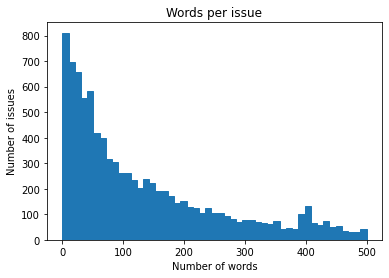

In [22]:
(df_issues["text"].str.split().apply(len)).hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0")
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

Most of the
texts are fairly short, but there are also issues with more than 500 words.

Given that most transformer models have a context size
of 512 tokens or larger, truncating a handful of long issues is not likely to affect the overall performance.

###Creating Training Sets

Creating training and validation sets is a bit trickier for multlilabel problems because
there is no guaranteed balance for all labels. However, it can be approximated, and we
can use the [Scikit-multilearn library](http://scikit.ml/), which is specifically set up for this purpose.

In [23]:
# takes a list of label names and creates a vector with zeros for absent labels and ones for present labels
mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [24]:
def balanced_split(df, test_size=0.5):
  index = np.expand_dims(np.arange(len(df)), axis=1)
  labels = mlb.transform(df["labels"])
  # creates the train/test splits iteratively to achieve balanced labels
  ind_train, _, ind_test, _ = iterative_train_test_split(index, labels, test_size)
  return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

Now, we can split the data into supervised
and unsupervised datasets, and then create balanced training, validation, and test sets.

In [25]:
np.random.seed(0)

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()

df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

Finally, let’s create a `DatasetDict` with all the splits so that we can easily tokenize the dataset and integrate with the `Trainer`.

In [26]:
ds = DatasetDict({
  "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
  "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
  "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
  "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

###Creating Training Slices

In [27]:
np.random.seed(0)

all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
  # Split off samples necessary to fill the gap to the next split size
  indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool, labels, (k - last_k) / len(labels))
  last_k = k
  if i == 0:
    train_slices.append(new_slice)
  else:
    train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices)
train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

Note that this iterative approach only approximately splits the samples to the desired
size, since it is not always possible to find a balanced split at a given split size:

In [28]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


##Implementing Naive Bayesline

For text classification, a great
baseline is a Naive Bayes classifier as it is very simple, quick to train, and fairly robust
to perturbations in the inputs. 

The Scikit-learn implementation of Naive Bayes does
not support multilabel classification out of the box, but fortunately we can again use
the Scikit-multilearn library to cast the problem as a one-versus-rest classification
task where we train L binary classifiers for L labels.

First, let’s use a multilabel binarizer
to create a new label_ids column in our training sets.

In [ ]:
def prepare_labels(batch):
  batch["label_ids"] = mlb.transform(batch["labels"])
  return batch

ds = ds.map(prepare_labels, batched=True)

let’s create a defaultdict with a list to store the scores
per split.

In [30]:
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

Now we’re finally ready to train our baseline!

In [31]:
for train_slice in train_slices:
  # Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)
  y_train = np.array(ds_train_sample["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])

  # Use a simple count vectorizer to encode our texts as token counts
  count_vec = CountVectorizer()
  x_train_counts = count_vec.fit_transform(ds_train_sample["text"])
  x_test_counts = count_vec.transform(ds["test"]["text"])

  # Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(x_train_counts, y_train)

  # Generate predictions and evaluate
  y_pred_test = classifier.predict(x_test_counts)
  clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)

  # Store metrics
  macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

Let's plot the results of this experiment.

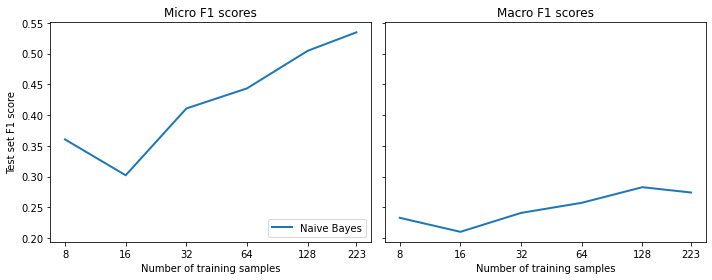

In [32]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

##Working with No Labeled Data

The first technique that we’ll consider is zero-shot classification, which is suitable in
settings where you have no labeled data at all. This is surprisingly common in industry,
and might occur because there is no historic data with labels or because acquiring
the labels for the data is difficult.

The goal of zero-shot classification is to make use of a pretrained model without any
additional fine-tuning on your task-specific corpus.

Let's try is to load BERT-base in the fillmask
pipeline, which uses the masked language model to predict the content of the
masked tokens:

In [ ]:
mask_pipeline = pipeline("fill-mask", model="bert-base-uncased")

Next, let’s construct a little movie description and add a prompt to it with a masked word.

In [34]:
movie_desc = "The main characters of the movie madacascar are a lion, a zebra, a giraffe, and a hippo."
prompt = "The movie is about [MASK]."

output = mask_pipeline(movie_desc + prompt)
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


We can also turn
this around, and instead of getting the most likely tokens we can query the pipeline
for the probability of a few given tokens.

In [35]:
output = mask_pipeline(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


Let’s see if this also works for a description that is closer to cars.

In [36]:
movie_desc = "In the movie transformers aliens can morph into a wide range of vehicles."

output = mask_pipeline(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


Using the masked language model for classification is a nice trick, but we can do better
still by using a model that has been trained on a task that is closer to classification.

There is a neat proxy task called text entailment that fits the bill. In text entailment,
the model needs to determine whether two text passages are likely to follow or contradict
each other.

Each sample in these datasets is composed of three parts: a premise, a hypothesis, and
a label, which can be one of entailment, neutral, or contradiction.

In [ ]:
zero_shot_pipe = pipeline("zero-shot-classification", device=0)

Let's classify a text, we simply need to pass it to the
pipeline along with the label names.

In [38]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")
output = zero_shot_pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nnPredictions:")

for label, score in zip(output["labels"], output["scores"]):
  print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

nPredictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


An important aspect for zeroshot
classification is the domain we’re operating in.

Let’s write a function that feeds a single example through the zero-shot pipeline.

In [39]:
def zero_shot_pipeline(example):
  output = zero_shot_pipe(example["text"], all_labels, multi_label=True)
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example

In [ ]:
ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

To help us determine which method is best, let’s write a function that
applies one of the approaches to retrieve the predictions.

In [41]:
def get_preds(example, threshold=None, topk=None):
  preds = []
  if threshold:
    for label, score in zip(example["predicted_labels"], example["scores"]):
      if score >= threshold:
        preds.append(label)
  elif topk:
    for i in range(topk):
      preds.append(example["predicted_labels"][i])
  else:
    raise ValueError("Set either `threshold` or `topk`.")
  return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

Next, let’s write a second function that returns the Scikit-learn
classification report from a dataset with the predicted labels.

In [42]:
def get_clf_report(ds):
  y_true = np.array(ds["label_ids"])
  y_pred = np.array(ds["pred_label_ids"])
  return classification_report(y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

Let’s start with the `top-k` method by increasing `k` for
several values and then plotting the micro and macro F1-scores across the validation set.

In [ ]:
macros, micros = [], []
topks = [1, 2, 3, 4]

for topk in topks:
  ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={"topk": topk})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])

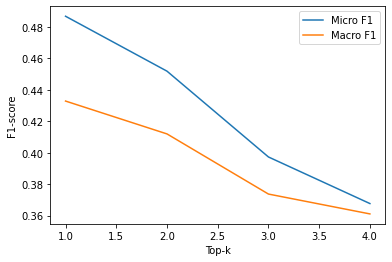

In [44]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

Let’s now compare this against setting a threshold, so we can potentially predict more than one label per example.

In [ ]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)

for threshold in thresholds:
  ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={"threshold": threshold})
  clf_report = get_clf_report(ds_zero_shot)
  micros.append(clf_report["micro avg"]["f1-score"])
  macros.append(clf_report["macro avg"]["f1-score"])

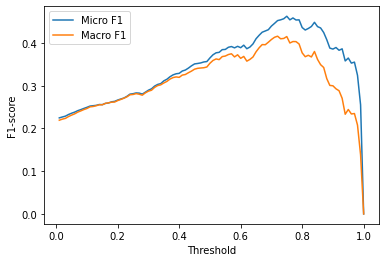

In [46]:
plt.plot(thresholds, micros, label='Micro F1')
plt.plot(thresholds, macros, label='Macro F1')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

In [47]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f"Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.")

best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f"Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.")

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (macro): 0.72 with F1-score 0.42.


Since the top-1 method performs best, let’s use this to compare zero-shot classification
against Naive Bayes on the test set.

In [ ]:
ds_zero_shot = ds["test"].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={"topk": 1})
clf_report = get_clf_report(ds_zero_shot)

for train_slice in train_slices:
  macro_scores["Zero Shot"].append(clf_report['macro avg']['f1-score'])
  micro_scores["Zero Shot"].append(clf_report['micro avg']['f1-score'])

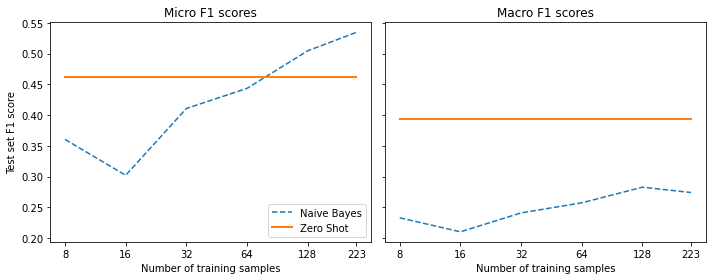

In [49]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

Comparing the zero-shot pipeline to the baseline, we observe two things:

1. If we have less than 50 labeled samples, the zero-shot pipeline handily outperforms the baseline.

2. Even above 50 samples, the performance of the zero-shot pipeline is superior
when considering both the micro and macro F1-scores. The results for the micro
F1-score tell us that the baseline performs well on the frequent classes, while the zero-shot pipeline excels at those since it does not require any examples to learn from.

##Working with a Few Labels

In most NLP projects, you’ll have access to at least a few labeled examples. The labels
might come directly from a client or cross-company team, or you might decide to just
sit down and annotate a few examples yourself.

Let’s start by looking at a technique known as data augmentation
that can help us multiply the little labeled data that we have.

###Data Augmentation

One simple but effective way to boost the performance of text classifiers on small
datasets is to apply data augmentation techniques to generate new training examples
from the existing ones.

For text, data augmentation is somewhat trickier because perturbing
the words or characters can completely change the meaning.

However, if the text
consists of more than a few sentences (like our GitHub issues do), then the noise
introduced by these types of transformations will generally not affect the label. 

In practice, there are two types of data augmentation techniques that are commonly used:

* Back translation
* Token perturbations

Let's see examples of these transformations.

In [ ]:
set_seed(3)

text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}

augs["synonym_replace"] = naw.SynonymAug(aug_src="wordnet")
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="insert", aug_max=1)
augs["random_swap"] = naw.RandomWordAug(action="swap")
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(from_model_name="facebook/wmt19-en-de", to_model_name="facebook/wmt19-de-en")

In [56]:
for k, v in augs.items():
  print(f"Original text: {text}")
  print(f"{k}: {v.augment(text)}")
  print("")

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to slowly defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



We’ll use the `ContextualWordEmbsAug` augmenter from `NlpAug` to leverage the contextual word embeddings of `DistilBERT` for our synonym replacements. 

Let’s start with a simple example:

In [57]:
set_seed(3)

aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="substitute")

In [58]:
text = "Transformers are the most popular toys"

print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: ['transformers have the most available toys']


We can wrap this augmentation in a simple function.

In [59]:
def augment_text(batch, transformations_per_example=1):
  text_aug, label_ids = [], []
  for text, labels in zip(batch["text"], batch["label_ids"]):
    text_aug += [text]
    label_ids += [labels] 
    for _ in range(transformations_per_example):
      text_aug += [aug.augment(text)]
      label_ids += [labels]
  return {"text": text_aug, "label_ids": label_ids}

Let's train the Naive Bayes classifier by simply adding one line after
we select the slice.

In [63]:
for train_slice in train_slices:
  # Get training slice and test data
  ds_train_sample = ds["train"].select(train_slice)

  # Flatten augmentations and align labels!
  ds_train_aug = (ds_train_sample.map(augment_text, batched=True, remove_columns=ds_train_sample.column_names).shuffle(seed=42))

  y_train = np.array(ds_train_aug["label_ids"])
  y_test = np.array(ds["test"]["label_ids"])

  # Use a simple count vectorizer to encode our texts as token counts
  count_vec = CountVectorizer()
  x_train_counts = count_vec.fit_transform(ds_train_aug["text"])
  x_test_counts = count_vec.transform(ds["test"]["text"])

  # Create and train our model!
  classifier = BinaryRelevance(classifier=MultinomialNB())
  classifier.fit(x_train_counts, y_train)

  # Generate predictions and evaluate
  y_pred_test = classifier.predict(x_test_counts)
  clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0, output_dict=True)

  # Store metrics
  macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
  micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?ba/s]

ArrowTypeError: ignored

After including this, now rerunning the analysis produces the plot.

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

###Using Embeddings as a Lookup Table